In [1]:
from modeling.gen6.api import symbolic, sqrt
from modeling.gen7.api7 import MFunctionalSet, MFunctionalSetLeaf
from engine.torchdata import print_formatted_table, load_vals, ExpandVector
from graph.matrixview import render_incidence
from graph.graphutils import default_tree, all_edges, all_variables
from graph.operators import reformulate
from graph.workflow import order_from_tree
from presolver.tearing import dir_graph, min_arc_set_assign
from scipy import optimize
import numpy as np
import torch

In [3]:
c, md, v, A, As, M, T, Ts, P, Ps = symbolic("c", "m_d", "v", "A", "A_s", "M", "T", "T_s", "P", "P_s")
rho, gamma, r = 1.225, 1.4, 270

D1 = MFunctionalSetLeaf(md == rho*v*A, idvals=[0])
D2 = MFunctionalSetLeaf(c == (gamma*r*T)**0.5, idvals=[1])
D3 = MFunctionalSetLeaf(v == M*c, idvals=[2])
D4 = MFunctionalSetLeaf(P == rho*r*T, idvals=[3])
D5 = MFunctionalSetLeaf(Ps == P*(1+(gamma-1)/2*M**2)**(gamma/(gamma-1)), idvals=[4])
D6 = MFunctionalSetLeaf(A == As/M*(2/(gamma+1)*(1+(gamma-1)/2*M**2))**((gamma+1)/(2*(gamma-1))), idvals=[5])
D7 = MFunctionalSetLeaf(md == (gamma/(r*Ts)*Ps*A*M*(1+(gamma-1)/2*M**2)**(-(gamma+1)/(2*(gamma-1)))), idvals=[6])

FPF = MFunctionalSet(D1,D2,D3,D4,D5,D6,D7)

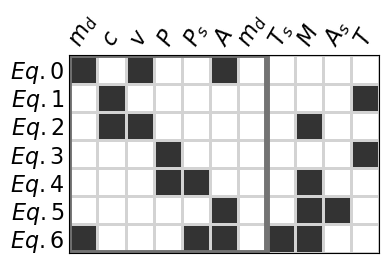

In [7]:
# get structure
sets, _,_,_, indices = FPF.gather_sets()
idxrev = {var.item():key for key,var in indices.items()}
in_outs = {eqid: D.analysis.structure for eqid, D in sets.items()}
Ein = {eqid: tuple(str(idxrev[idx.item()]) for idx in item[0]) for eqid, item in in_outs.items()}
Eout = {eqid: tuple(str(idxrev[idx.item()]) for idx in item[1]) for eqid, item in in_outs.items()}
edges = Ein, Eout, {}
sorted_keys = sorted(Ein.keys())
tree = default_tree(sorted_keys)
render_incidence(edges, tree, rawvarname=True, dispendcomp=False, hideticks=True, patchwidth=4, figsize=((4,4)),diagonalgray=False);

In [8]:
graph_edges_minassign = all_edges(*edges)
varidxs = all_variables(*edges)
eqnidxs = list(edges[1].keys())
edges_left_right = list(dir_graph(graph_edges_minassign, eqnidxs, {}))

In [23]:
xsol,_ = min_arc_set_assign(edges_left_right, varidxs, eqnidxs)
outset_initial = {comp: var[0] for comp,var in edges[1].items()}
outset_opt = {right:left for left, right in edges_left_right 
                  if (left,right) in edges_left_right and xsol[left, right] > 0.5}

In [24]:
outset_opt

{6: 'T_s', 5: 'A_s', 2: 'M', 1: 'T', 0: 'A', 4: 'P_s', 3: 'P'}

In [25]:
str2symb = {str(key):key for key in indices.keys()}
outset_symb = {key:symbolic(str2symb[val])[0] for key,val in outset_opt.items()}
edges_new, tree_new = reformulate(edges, tree, outset_initial, outset_opt, root_solver_name=1)
workflow_order = order_from_tree(tree_new[0], tree_new[1], Eout=edges_new[1])

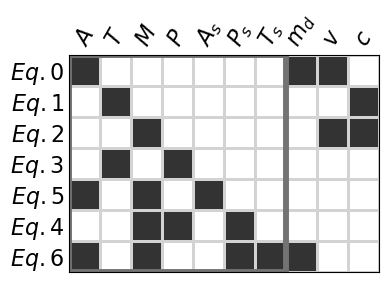

In [30]:
render_incidence(edges_new, tree_new, rawvarname=True, dispendcomp=False, hideticks=True, patchwidth=4, figsize=((4,4)),diagonalgray=False);

In [26]:
FPFr = FPF.reconfigure(outset_symb).config_from_workflow(workflow_order)
#FPF_MDF = FPF.config(elim=[D3, D2, D1]) # Manual configuration
formulation_of_choice = FPFr

In [27]:
f = FPFr.build()

In [29]:
x0 = load_vals({'m_d': 1, 'v':0.1, 'c':1}, f.indices, isdict=True)
xsol = f.analysis(x0)
idxrev = {var.item():key for key,var in f.indices.items()}
print_formatted_table([np.round(xsol,2)], f.indices, idxrev)

m_d M   P_s  T A    P    T_s A_s v   c
1   0.1 0.88 0 8.16 0.87 0   1.4 0.1 1
